In [1]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np

from phase_space_reconstruction.virtual.beamlines import quad_drift
from phase_space_reconstruction.virtual.scans import run_quad_scan
from phase_space_reconstruction.diagnostics import ImageDiagnostic
from phase_space_reconstruction.train import train_1d_scan

from bmadx.plot import plot_projections
from phase_space_reconstruction.visualization import plot_scan_data, plot_predicted_screens

In [2]:
#convert saved BELLA quad scan data into correct format for subsequent analysis
from PIL import Image, ImageOps
import re

# Function to pad the images to be square
def pad_to_square(img):
    width, height = img.size
    new_size = max(width, height)
    delta_w = new_size - width
    delta_h = new_size - height
    padding = (delta_w//2, delta_h//2, delta_w-(delta_w//2), delta_h-(delta_h//2))
    return ImageOps.expand(img, padding)

# Function to get all image files from a specified directory
def get_image_files(dir_path):
    # Get a list of all files with the specified extensions
    files = [f for f in os.listdir(dir_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    # Extract the number from each filename and sort the files based on these numbers
    sorted_files = sorted(files, key=lambda x: int(re.search(r'_(\d+)', x).group(1)))
    
    return sorted_files

# Get a list of all image files in the specified directory
image_folder_path = "16bit_images/"
image_files = get_image_files(image_folder_path)

# Open, pad to make square, and resize each image, then convert them to grayscale
image_list = []
for file in image_files:
    img = Image.open(os.path.join(image_folder_path, file))
    img = pad_to_square(img)
    
    # Get the new dimensions after padding
    width, height = img.size
    
    # Crop 200 pixels from each edge
    img = img.crop((200, 200, width - 200, height - 200))
    
    img = img.resize((200, 200))
    image_list.append(np.array(img, dtype=np.float32))

# Convert the images to a torch tensor
images_tensor = torch.stack([torch.tensor(np.array(img)) for img in image_list])

# Add an extra dimension for the channel (grayscale)
images_tensor = images_tensor.unsqueeze(1)

images=images_tensor.double()



# convert quad current values to normalized k values
def EMQ3CurToGrad(cur):
    return 2.9016 * cur + 0.093

def gradientToK(gradient,energy):
    return gradient*299.8/energy

currents=np.linspace(1.3,2.3,11)
gradients = EMQ3CurToGrad(currents)

# Fixed value of energy
energy = 110

# # Convert the gradients tensor to a numpy array for easier manipulation
# gradients_numpy = gradients.numpy()

# Apply the function to each gradient value
k_values_numpy = gradientToK(gradients, energy)

# Convert the k_values back to a torch tensor
k_values_tensor = torch.tensor(k_values_numpy).unsqueeze(1).unsqueeze(2).double()

# k_values_tensor = k_values_tensor.unsqueeze(1).unsqueeze(2)
ks=k_values_tensor

In [3]:
from phase_space_reconstruction.modeling import ImageDataset, ImageDataset3D

# create image dataset
save_as='test.dset'
dset = ImageDataset(ks[1::2], images[::2])

# save scan data if wanted
if save_as is not None:
    # Include the path to the "data" directory in the save_as variable
    save_as = os.path.join("data", save_as)
    
    # Check if the "data" directory exists, if not, create it
    if not os.path.exists("data"):
        os.makedirs("data")
    
    # Save the dataset in the "data" directory
    torch.save(dset, save_as)
    print(f"dataset saved as '{save_as}'")
    
    
# create image dataset
save_as='train.dset'
dset = ImageDataset(ks[::2], images[::2])

# save scan data if wanted
if save_as is not None:
    # Include the path to the "data" directory in the save_as variable
    save_as = os.path.join("data", save_as)
    
    # Check if the "data" directory exists, if not, create it
    if not os.path.exists("data"):
        os.makedirs("data")
    
    # Save the dataset in the "data" directory
    torch.save(dset, save_as)
    print(f"dataset saved as '{save_as}'")

dataset saved as 'data\test.dset'
dataset saved as 'data\train.dset'


In [4]:
data_dir = 'data'

In [5]:
# load data:
train_dset = torch.load(os.path.join(data_dir,'train.dset'))
test_dset = torch.load(os.path.join(data_dir,'test.dset'))

# image bins: 
bins_x = torch.linspace(-7.32, 7.32, train_dset.images.shape[-2])*1e-3
bins_y = torch.linspace(-7.32, 7.32, train_dset.images.shape[-1])*1e-3

image size = 15 x 15 mm
test samples boxed in orange


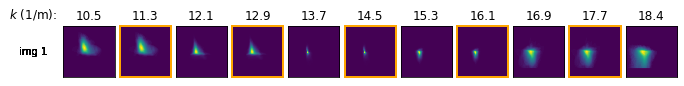

In [6]:
fig, ax = plot_scan_data(train_dset, test_dset, bins_x, bins_y)
plt.show()

In [7]:
# diagnostic beamline:
lattice = quad_drift(l_d=2.126, l_q=0.1409)

# design momentum (eV)
p0c = energy* 1e6

# diagnostic screen: 
bandwidth = (bins_x[1]-bins_x[0]) / 2
screen = ImageDiagnostic(bins_x, bins_y, bandwidth)

C:\Users\loasis\Desktop\PhaseSpaceReconstructionRepos\phase_space_reconstruction\phase_space_reconstruction\diagnostics.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("bandwidth", torch.tensor(bandwidth))


Using device: cpu


C:\Users\loasis\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


0 tensor(1.7865e+13, dtype=torch.float64, grad_fn=<MulBackward0>)
100 tensor(1.7865e+13, dtype=torch.float64, grad_fn=<MulBackward0>)
200 tensor(1.7865e+13, dtype=torch.float64, grad_fn=<MulBackward0>)
300 tensor(1.7865e+13, dtype=torch.float64, grad_fn=<MulBackward0>)
400 tensor(1.7865e+13, dtype=torch.float64, grad_fn=<MulBackward0>)
image size = 15 x 15 mm
test samples boxed in orange
Using device: cpu
0 tensor(1.7865e+13, dtype=torch.float64, grad_fn=<MulBackward0>)
100 tensor(1.7865e+13, dtype=torch.float64, grad_fn=<MulBackward0>)
200 tensor(1.7865e+13, dtype=torch.float64, grad_fn=<MulBackward0>)
300 tensor(1.7865e+13, dtype=torch.float64, grad_fn=<MulBackward0>)
400 tensor(1.7865e+13, dtype=torch.float64, grad_fn=<MulBackward0>)
image size = 15 x 15 mm
test samples boxed in orange
Using device: cpu
0 tensor(1.7865e+13, dtype=torch.float64, grad_fn=<MulBackward0>)
100 tensor(1.7865e+13, dtype=torch.float64, grad_fn=<MulBackward0>)
200 tensor(1.7865e+13, dtype=torch.float64, grad

C:\Users\loasis\Desktop\PhaseSpaceReconstructionRepos\Bmad-X\bmadx\plot.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(n_coords, n_coords, figsize=fig_size)


Using device: cpu
0 tensor(1.7865e+13, dtype=torch.float64, grad_fn=<MulBackward0>)
100 tensor(1.7865e+13, dtype=torch.float64, grad_fn=<MulBackward0>)
200 tensor(1.7865e+13, dtype=torch.float64, grad_fn=<MulBackward0>)
300 tensor(1.7865e+13, dtype=torch.float64, grad_fn=<MulBackward0>)
400 tensor(1.7865e+13, dtype=torch.float64, grad_fn=<MulBackward0>)
image size = 15 x 15 mm
test samples boxed in orange
Using device: cpu
0 tensor(1.7865e+13, dtype=torch.float64, grad_fn=<MulBackward0>)
100 tensor(1.7865e+13, dtype=torch.float64, grad_fn=<MulBackward0>)
200 tensor(1.7865e+13, dtype=torch.float64, grad_fn=<MulBackward0>)
300 tensor(1.7865e+13, dtype=torch.float64, grad_fn=<MulBackward0>)
400 tensor(1.7865e+13, dtype=torch.float64, grad_fn=<MulBackward0>)
image size = 15 x 15 mm
test samples boxed in orange
Using device: cpu
0 tensor(1.7865e+13, dtype=torch.float64, grad_fn=<MulBackward0>)
100 tensor(1.7865e+13, dtype=torch.float64, grad_fn=<MulBackward0>)
200 tensor(1.7865e+13, dtype=t

<Figure size 432x288 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 864x144 with 0 Axes>

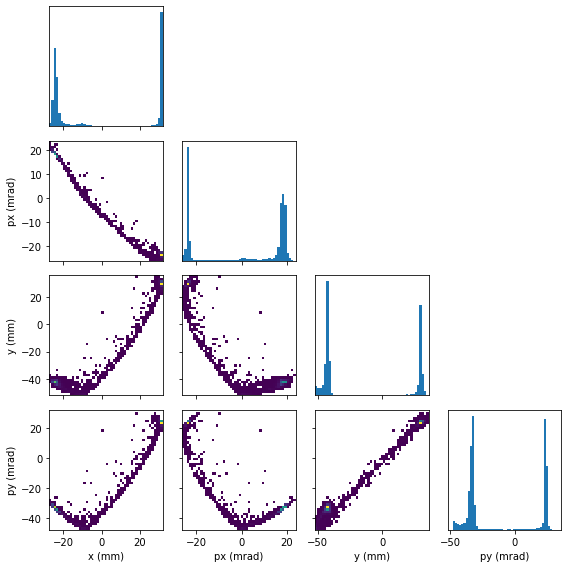

In [8]:
for i in range(100):
    output_folder_path = "loop_output/"
    index_string = "{:03d}".format(i)

    # training
    pred_beam = train_1d_scan(train_dset, lattice, p0c, screen, n_epochs=500)
    ks = torch.vstack((train_dset.k, test_dset.k))
    pred_dset = run_quad_scan(pred_beam, lattice, screen, ks)

    # compare predicted screens with data
    plt.clf()
    fig, ax = plot_predicted_screens(pred_dset, train_dset, test_dset, bins_x, bins_y)
    plt.savefig(output_folder_path+'pred_'+index_string+'.png')

    # reconstructed beam projections: 
    plt.clf()
    fig, ax = plot_projections(pred_beam.numpy_particles(),
                           coords=['x', 'px', 'y', 'py'],
                           bins=50,
                           background=False
                           )
    plt.savefig(output_folder_path+'recon_'+index_string+'.png')

    stacked_output = np.vstack((pred_beam.x.numpy(),pred_beam.y.numpy(),pred_beam.z.numpy(),pred_beam.px.numpy(),pred_beam.py.numpy(),pred_beam.pz.numpy()))
    np.save(output_folder_path+'phasespace_'+index_string+'.npy', stacked_output)

In [12]:
# training
pred_beam = train_1d_scan(train_dset, lattice, p0c, screen, n_epochs=500)

Using device: cpu
0 tensor(1.7865e+13, dtype=torch.float64, grad_fn=<MulBackward0>)
100 tensor(1.7865e+13, dtype=torch.float64, grad_fn=<MulBackward0>)
200 tensor(1.7865e+13, dtype=torch.float64, grad_fn=<MulBackward0>)
300 tensor(1.7865e+13, dtype=torch.float64, grad_fn=<MulBackward0>)
400 tensor(1.7865e+13, dtype=torch.float64, grad_fn=<MulBackward0>)


In [13]:
# predicted screens:
ks = torch.vstack((train_dset.k, test_dset.k))
pred_dset = run_quad_scan(pred_beam, lattice, screen, ks)

image size = 15 x 15 mm
test samples boxed in orange


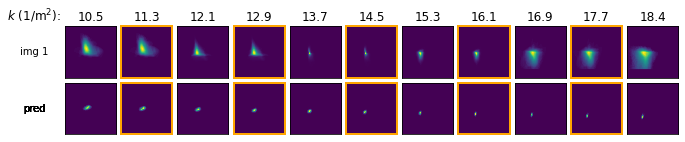

In [14]:
# compare predicted screens with data
fig, ax = plot_predicted_screens(pred_dset, train_dset, test_dset, bins_x, bins_y)
plt.show()

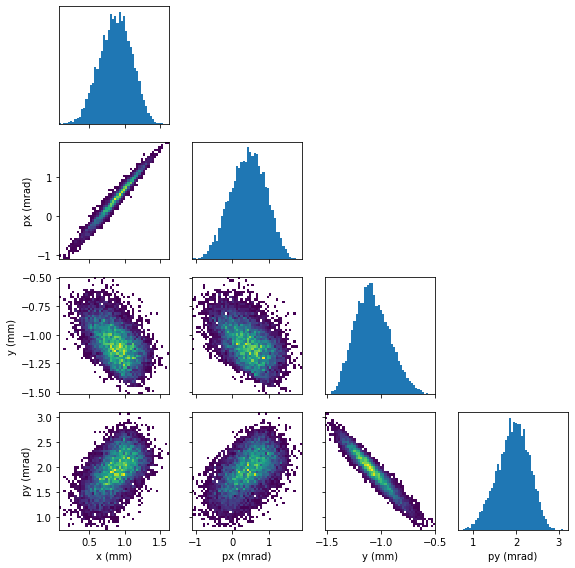

In [15]:
# reconstructed beam projections: 
fig, ax = plot_projections(pred_beam.numpy_particles(),
                           coords=['x', 'px', 'y', 'py'],
                           bins=50,
                           background=False
                           )
plt.show()

In [21]:
stacked_output = np.vstack((pred_beam.x.numpy(),pred_beam.y.numpy(),pred_beam.z.numpy(),pred_beam.px.numpy(),pred_beam.py.numpy(),pred_beam.pz.numpy()))

In [22]:
output_folder_path = "loop_output/"
np.save(output_folder_path+'test.npy', stacked_output)